In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import bernoulli, binom

# Part 1: Empirical Learning Rates for the Exponential Weights Algorithm

In [21]:
class EWAlg:
    def __init__(self, epsilon, k, h):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return j.item()
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        if(self.epsilon > 10):
            self.weights = self.weights/self.sumWeights
            self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return


In [47]:
class AdversarialFair:
    def __init__(self, k):
        self.totalPayoffs = np.zeros(k)
        self.k = k
        
    def generate(self):
        adversarialPayoffs = np.zeros(self.k)
        x = np.random.rand(1)
        least = np.argmin(self.totalPayoffs)
        adversarialPayoffs[least] = x
        self.totalPayoffs = self.totalPayoffs + adversarialPayoffs
        return adversarialPayoffs

In [49]:
def MonteCarlo(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            OPT = max(actionPayoffs)
            regret = (OPT - myPayoff).item() / (i + 1)
            regretPerRound[i] = regret
            finalPayoff += myPayoff
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, regretPerRound

## Adversarial Fair Payoffs

In each round i:

Draw a payoff x ~ U[0,1] (i.e., from the uniform distribution on interval [0,1])

Assign this payoff to the action j* that has the smallest total payoff so far, i.e., j* = argminj Vji-1 where Vji = Σir=1 vji. 
(All other actions get 0 payoff in round i.)

In [51]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000] # to be studied
monteCarloBound = 1000

epsilonPayoffs = []
epsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, AdversarialFair, epsilon, k, h, n)
    epsilonPayoffs.append(finalPayoff)
    regretPerRound = np.mean(regretPerRound, axis=0)
    epsilonRegretPerRound.append(regretPerRound)

epsilonAvgRegrets = [max(i) for i in epsilonRegretPerRound]
print(epsilons)
print(epsilonPayoffs)
print(epsilonAvgRegrets)

TypeError: 'numpy.float64' object is not iterable

### Graphs for Adversarial Payoffs

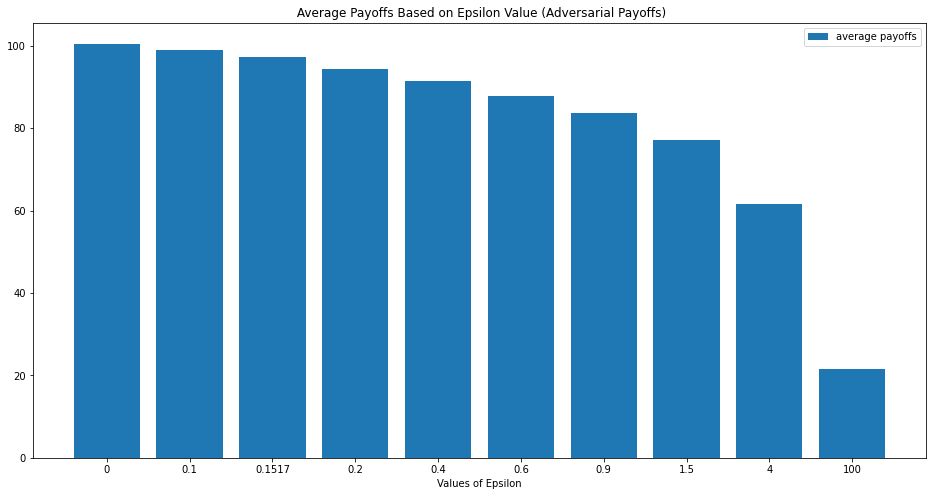

In [15]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, avgPayoffs, label = "average payoffs")

plt.xticks(X_axis, epsilons)
plt.xlabel("Values of Epsilon")
# plt.ylabel("Expected Utility")
plt.title(" Average Payoffs Based on Epsilon Value (Adversarial Payoffs)")
plt.legend()
plt.show()

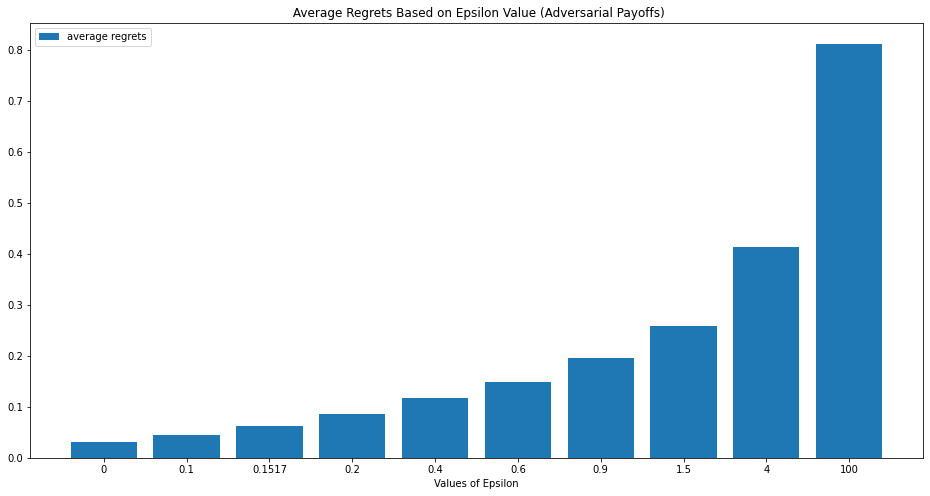

In [16]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, avgRegrets, label = "average regrets")
plt.xticks(X_axis, epsilons)
plt.xlabel("Values of Epsilon")
# plt.ylabel("Expected Utility")
plt.title(" Average Regrets Based on Epsilon Value (Adversarial Payoffs)")
plt.legend()
plt.show()


/var/folders/r2/zpk7_6mj6995g1gtd80hvc0w0000gn/T/ipykernel_4488/3548613573.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons), avgPayoffs, label = 'Size 1', color = "red")


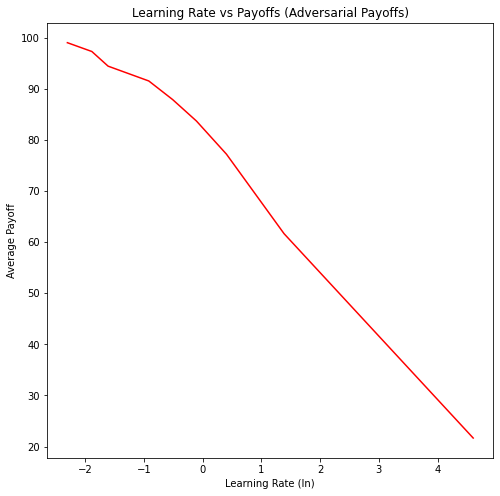

/var/folders/r2/zpk7_6mj6995g1gtd80hvc0w0000gn/T/ipykernel_4488/3548613573.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons),avgRegrets)


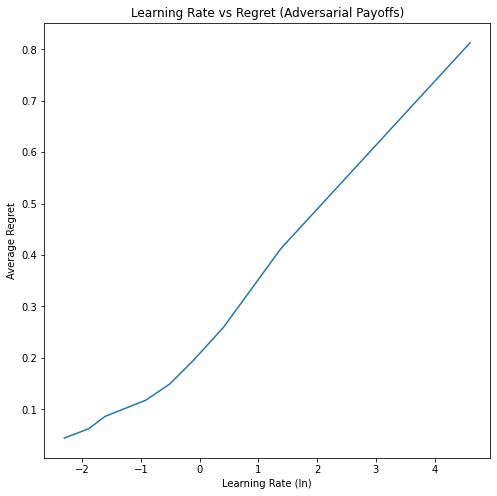

In [17]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.plot(np.log(epsilons), avgPayoffs, label = 'Size 1', color = "red")
plt.title('Learning Rate vs Payoffs (Adversarial Payoffs)')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Payoff')
plt.show()

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(np.log(epsilons),avgRegrets)
plt.title('Learning Rate vs Regret (Adversarial Payoffs)')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Regret')
plt.show()

## Bernoulli Payoffs

Fix a probability for each action p1,...,pk with each pk in [0,1/2].

In each round i, draw the payoff of each action j as vji ~ B(pj) (i.e, from the Bernoulli distribution with probability pj of being 1 and probability 1-pj of being 0).

In [18]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100] # to be studied
monteCarloBound = 125

avgBernoulliPayoffs = []
avgBernoulliRegrets = []
for epsilon in epsilons:
    sumPayoff = 0
    sumRegret = 0   
    for i in range(monteCarloBound):
        payoffProbs = np.random.uniform(0, 0.5, k)
        bernouliPayoffs = [bernoulli(p) for p in payoffProbs]
        alg = EWAlg(epsilon, k, h)
        totalPayoffs = np.zeros(k)
        myPayoff = 0
        for i in range(n):
            # generate bernouli payoffs
            iPayoffs = np.array([b.rvs(1) for b in bernouliPayoffs]).flatten()
            totalPayoffs = totalPayoffs + iPayoffs
            j = alg.getAction()
            myPayoff += iPayoffs[j]
            alg.update(iPayoffs)

        OPT = max(totalPayoffs)
        regret = (OPT - myPayoff).item() / n
        sumPayoff += myPayoff
        sumRegret += regret
    avgBernoulliPayoffs.append(sumPayoff/n)
    avgBernoulliRegrets.append(sumRegret/n)

print(epsilons)
print(avgBernoulliPayoffs)
print(avgBernoulliRegrets)

[0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100]
[31.48, 40.99, 43.4, 45.28, 48.15, 51.21, 50.55, 51.67, 51.95, 53.68]
[0.27000000000000013, 0.1874, 0.15110000000000007, 0.13790000000000002, 0.10049999999999995, 0.08249999999999995, 0.07979999999999998, 0.07109999999999995, 0.06479999999999993, 0.05729999999999995]


/var/folders/r2/zpk7_6mj6995g1gtd80hvc0w0000gn/T/ipykernel_4488/3946239780.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons), avgBernoulliPayoffs, color = "red")


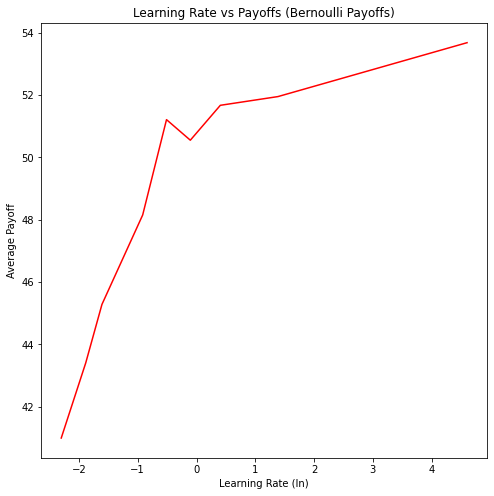

/var/folders/r2/zpk7_6mj6995g1gtd80hvc0w0000gn/T/ipykernel_4488/3946239780.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons),avgBernoulliRegrets, color="blue")


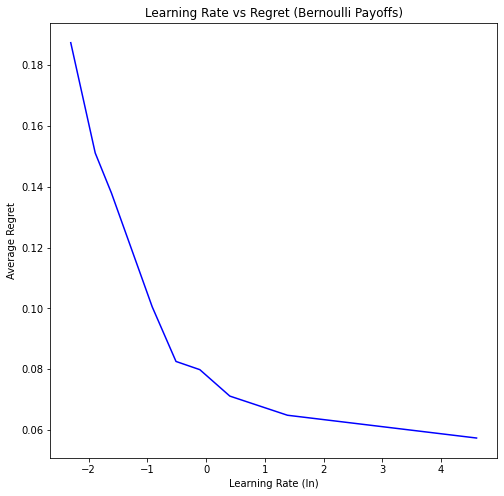

In [19]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.plot(np.log(epsilons), avgBernoulliPayoffs, color = "red")
plt.title('Learning Rate vs Payoffs (Bernoulli Payoffs)')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Payoff')
plt.show()

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(np.log(epsilons),avgBernoulliRegrets, color="blue")
plt.title('Learning Rate vs Regret (Bernoulli Payoffs)')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Regret')
plt.show()

In [21]:
# data source: http://ergast.com/mrd/
# f1Results = pd.read_csv("/Users/prabhavjain/Downloads/f1db_csv/constructor_results.csv")
# f1Races = pd.read_csv("/Users/prabhavjain/Downloads/f1db_csv/races.csv")
# f1Data = pd.merge(f1Results, f1Races, how="left", on="raceId")
# f1Data = f1Data[f1Data['year'] > 2018]
# f1Data = f1Data.drop(columns=['fp1_date', 'fp2_date', 'fp3_date', 'fp1_time', 'fp2_time', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'])
# f1Data = f1Data.drop(columns=['constructorResultsId', 'raceId', 'url', 'time', 'name', 'circuitId', 'round', 'status', 'year'])
# constructorID = [9, 6, 210, 4, 131, 51, 211, 5, 1, 3, 213, 117, 214]
# constructorNames = ["Red Bull", "Ferrari", "Haas", "Alpine", "Mercedes", "Alfa Romeo", "Aston Martin", "Alpha Tauri", "Mclaren", "Williams", "Alpha Tauri", "Aston Martin", "Alpine"]
# f1Data['constructorId'] = f1Data['constructorId'].replace(constructorID, constructorNames)
# f1Data['points'] = f1Data['points'].astype('int')
# f1Data = f1Data.pivot(index='date', columns='constructorId', values='points')
# # f1Data.to_csv("/Users/prabhavjain/Northwestern Google Drive/CS 332/Online-Markets/f1Data.csv")

# to load data for future
f1Data = pd.read_csv("/Users/allisonrhee/Online-Markets/f1Data.csv")

In [25]:
h = 58 # fixed
# hyperparameters
k = 10 # ten constructors
n = 82 # number of races
epsilons = [0, 1000, 0.1675717936] # adversarial optimal, bernoulli optimal, theoretical optimal
monteCarloBound = 1000
f1Payoffs = np.array(f1Data)

avgPayoffs = []
avgRegrets = []
for epsilon in epsilons:
    sumPayoff = 0
    sumRegret = 0   
    for i in range(monteCarloBound):
        alg = EWAlg(epsilon, k, h)
        totalPayoffs = np.zeros(k)
        myPayoff = 0
        for iPayoff in f1Payoffs:
            iPayoff = iPayoff[1:] #remove the date from first element
            # generate bernouli payoffs
            totalPayoffs = totalPayoffs + iPayoff
            j = alg.getAction()
            myPayoff += iPayoff[j]
            alg.update(iPayoff)

        OPT = max(totalPayoffs)
        regret = (OPT - myPayoff) / n
        sumPayoff += myPayoff
        sumRegret += regret
    avgPayoffs.append(sumPayoff/n)
    avgRegrets.append(sumRegret/n)

print(epsilons)
print(avgPayoffs)
print(avgRegrets)

[0, 1000, 0.1675717936]
[10240.365853658537, 29293.0, 20825.40243902439]
[237.9967281380129, 5.647531231409878, 108.91091612135635]


## Adversarial Generative Model

In [40]:
h = 1 # fixed
# hyperparameters
k = 10
n = 300
epsilons = [0, 0.1517, 1000] # to be studied
monteCarloBound = 100

avgPayoffs = []
avgRegrets = []
epsilonRegrets = []
for epsilon in epsilons:
    sumPayoff = 0
    sumRegret = 0  
    regretOverTime = [0 for i in range(monteCarloBound)]
    for z in range(monteCarloBound):
        alg = EWAlg(epsilon, k, h)
        totalPayoffs = np.zeros(k)
        myPayoff = 0
        regrets = np.zeros(n)
        for i in range(n):
            # generate adversarial payoffs
            adversarialPayoffs = np.zeros(k)
            x = np.random.rand(1)
            if (totalPayoffs[0] > totalPayoffs[1]): adversarialPayoffs[1] += x
            else : adversarialPayoffs[0] += x
            totalPayoffs = totalPayoffs + adversarialPayoffs
            j = alg.getAction()
            myPayoff += adversarialPayoffs[j]
            alg.update(adversarialPayoffs)
            OPT = max(totalPayoffs)
            regret = (OPT - myPayoff).item() / (i + 1)
            regrets[i] = regret
        regretOverTime[z] = regrets
        OPT = max(totalPayoffs)
        regret = (OPT - myPayoff).item() / n
        sumPayoff += myPayoff
        sumRegret += regret
    avgPayoffs.append(sumPayoff/n)
    avgRegrets.append(sumRegret/n)
    regretOverTime = np.mean(regretOverTime, axis=0)
    epsilonRegrets.append(regretOverTime)

print(epsilons)
print(avgPayoffs)
print(avgRegrets)

[0, 0.1517, 1000]
[4.980148102973924, 20.680244949125022, 8.207890100529767]
[0.06627078330544403, 0.014237631203023824, 0.055900127972381725]


In [36]:
print(regretOverTime[0]
)

0.49455645166157197


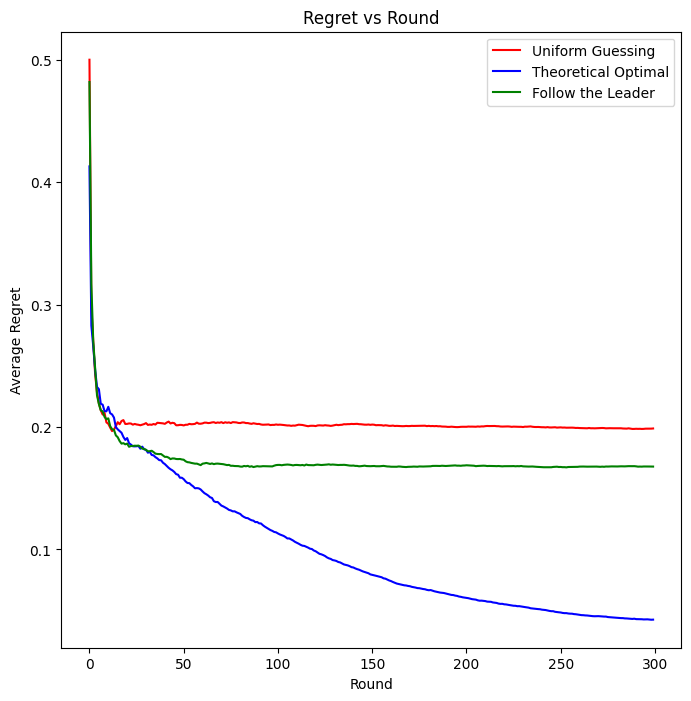

In [43]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.plot(np.arange(n), epsilonRegrets[0], color = "red", label = "Uniform Guessing")
plt.plot(np.arange(n), epsilonRegrets[1], color = "blue", label = "Theoretical Optimal")
plt.plot(np.arange(n), epsilonRegrets[2], color = "green", label = "Follow the Leader")
plt.title('Regret vs Round')
plt.xlabel('Round')
plt.ylabel('Average Regret')
plt.legend()
plt.show()